## I] Importing libraries and data

In [164]:
'''importing libraries'''
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.utils as kutils
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

# suppress scintific notation warnings in numpy
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc

In [165]:
'''Importing the data'''
labels = pd.read_csv('../Data/Labels.csv')['Label']
data = np.load('../Data/images.npy')
print(labels.shape)
print(data.shape)
if labels.shape[0]==data.shape[0]:
    print('The number of labels and number of images correspond')
else:
    print('Check input data')

(4750,)
(4750, 128, 128, 3)
The number of labels and number of images correspond


## II] Visualizing data and categories

In [166]:
'''Printing the categories and storing the number of classes'''
categories = labels.unique()
print(categories)
nclass = np.size(categories)
print('\nNumber of classes = ', nclass)

['Small-flowered Cranesbill' 'Fat Hen' 'Shepherds Purse' 'Common wheat'
 'Common Chickweed' 'Charlock' 'Cleavers' 'Scentless Mayweed' 'Sugar beet'
 'Maize' 'Black-grass' 'Loose Silky-bent']

Number of classes =  12


The plant sampling is: Common Chickweed


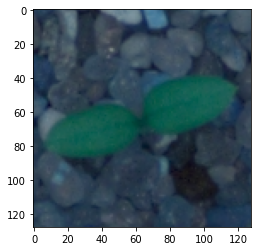

In [117]:
'''Plotting image'''
i = 2000
plt.imshow(data[i])
print('The plant sampling is:', labels[i])

## III] Data pre-processing

In [167]:
'''One hot encoding to make labels data into 2D matrix of categorical variables'''
encoder = preprocessing.LabelEncoder()
encoder.fit(labels)
labels_transformed = encoder.transform(labels)
labels_cat = kutils.to_categorical(labels_transformed)

print(labels_cat.shape)
labels_cat[1]

(4750, 12)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [161]:
'''Splittling the data into test, valid and train datasets'''
x_train,x_valid,y_train,y_valid = train_test_split(data, labels_cat,test_size=0.3,random_state=1,stratify=labels_cat)

In [162]:
xvalid, xtest, yvalid, ytest = train_test_split(x_valid, y_valid, test_size=0.5)

In [163]:
y_train.shape

(3325, 12)

<AxesSubplot:>

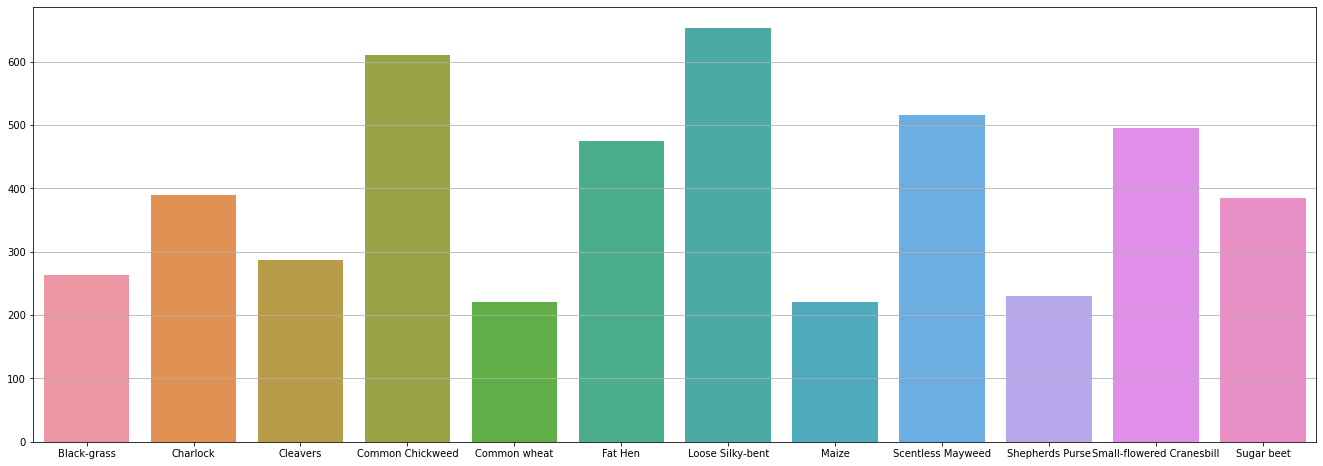

In [168]:
'''Visualizing the label data and its categories'''
y_arr = np.array(labels)
np.unique(y_arr.flatten(), return_counts = True)[0]
plt.figure(figsize=(23,8))
plt.grid()
sns.barplot(np.unique(y_arr.flatten(), return_counts = True)[0], np.unique(y_arr.flatten(), return_counts = True)[1])

In [169]:
x_train = x_train.astype('float32') # Converting integer to float type 
xvalid = x_valid.astype('float32')
x_train = x_train/255.0 # normalizing
xvalid = x_valid/255.0

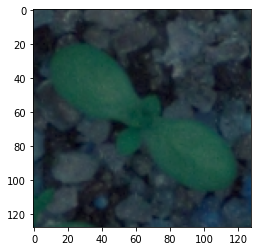

In [170]:
plt.imshow(x_train[i])

#### Comment
1. Data has been flattened and normalized, hence is made compatible for building the model

## IV] Building CNN

In [171]:
'''building the model'''
tf.keras.backend.clear_session()
#sequential model initializing
model = Sequential()
#adding 1st convolution layer with 64 filters and imput shape 128 x128x3 with relu function
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu'))
#normalising batch
model.add(BatchNormalization(axis=3))
#adding 2nd convolution layer with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
#maxpooling
model.add(MaxPooling2D((2, 2)))
#normalising batch
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
#adding 3rd convolution layer with 32 filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
#normalising batch
model.add(BatchNormalization(axis=3))
#adding 4th convolution layer with 32 filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
#maxpooling
model.add(MaxPooling2D((2, 2)))
#normalising batch
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
# Global Max pooling layer
model.add(GlobalMaxPool2D())

#flattening layer
model.add(Flatten())
#Dense layer
#adding 1 st dense layer
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#adding 2 nd dense layer
model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#adding dense layer with number of outputs = nclass with softmax function
model.add(Dense(nclass, activation='softmax'))

In [172]:
'''Constructing model checkpoint'''
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1)

#Saving best weights

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto')

In [173]:
'''Inserting an optimizer'''
optA = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optA, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
'''running the constructed model'''
model_history=model.fit(x_train, y_train, epochs=100, validation_data=(xvalid,yvalid),
                        shuffle=True, verbose=1, callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
104/104 [==============================] - ETA: 0s - loss: 3.2762 - accuracy: 0.1113
Epoch 00001: val_loss improved from inf to 2.85851, saving model to cifar_cnn_checkpoint_01_loss2.8585.h5
104/104 [==============================] - 261s 3s/step - loss: 3.2762 - accuracy: 0.1113 - val_loss: 2.8585 - val_accuracy: 0.1088
Epoch 2/100
104/104 [==============================] - ETA: 0s - loss: 2.5584 - accuracy: 0.2072
Epoch 00002: val_loss did not improve from 2.85851
104/104 [==============================] - 262s 3s/step - loss: 2.5584 - accuracy: 0.2072 - val_loss: 3.0502 - val_accuracy: 0.0989
Epoch 3/100
104/104 [==============================] - ETA: 0s - loss: 2.2027 - accuracy: 0.2689
Epoch 00003: val_loss did not improve from 2.85851
104/104 [==============================] - 267s 3s/step - loss: 2.2027 - accuracy: 0.2689 - val_loss: 4.0240 - val_accuracy: 0.0484
Epoch 4/100
104/104 [==============================] - ETA: 0s - loss: 1.9457 - accuracy: 0.3374
Epoch 00

Epoch 29/100
104/104 [==============================] - ETA: 0s - loss: 0.6381 - accuracy: 0.7841
Epoch 00029: val_loss did not improve from 0.51744
104/104 [==============================] - 259s 2s/step - loss: 0.6381 - accuracy: 0.7841 - val_loss: 1.1108 - val_accuracy: 0.6267
Epoch 30/100
104/104 [==============================] - ETA: 0s - loss: 0.6330 - accuracy: 0.7904
Epoch 00030: val_loss did not improve from 0.51744
104/104 [==============================] - 259s 2s/step - loss: 0.6330 - accuracy: 0.7904 - val_loss: 0.6475 - val_accuracy: 0.7719
Epoch 31/100
104/104 [==============================] - ETA: 0s - loss: 0.6130 - accuracy: 0.7850
Epoch 00031: val_loss did not improve from 0.51744
104/104 [==============================] - 258s 2s/step - loss: 0.6130 - accuracy: 0.7850 - val_loss: 0.9172 - val_accuracy: 0.6954
Epoch 32/100
104/104 [==============================] - ETA: 0s - loss: 0.5912 - accuracy: 0.8054
Epoch 00032: val_loss did not improve from 0.51744
104/104 

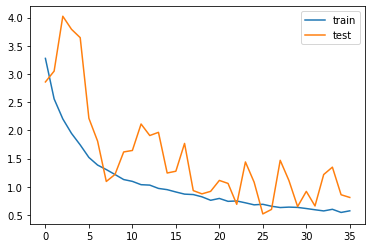

In [29]:
# plot training history
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.legend()
plt.show()

## V] Fitting and evaluation

In [174]:
'''Printing the score of the trained model'''
scores = model.evaluate(xvalid, yvalid, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

ValueError: Data cardinality is ambiguous:
  x sizes: 1425
  y sizes: 712
Please provide data which shares the same first dimension.

In [31]:
'''Predicting'''
ypred = model.predict_classes(x_valid)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [134]:
 '''Reversing one hot encoding for y_valid data'''
y = pd.DataFrame({'Small-flowered Cranesbill':[0,0,0,0,0,0,0,0,0,0,1,0], 'Fat Hen':[0,0,0,0,0,1,0,0,0,0,0,0],
                  'Shepherds Purse':[0,0,0,0,0,0,0,0,0,1,0,0], 'Common wheat':[0,0,0,0,1,0,0,0,0,0,0,0],
                  'Common Chickweed':[0,0,0,1,0,0,0,0,0,0,0,0], 'Charlock':[0,1,0,0,0,0,0,0,0,0,0,0],
                  'Cleavers':[0,0,1,0,0,0,0,0,0,0,0,0], 'Scentless Mayweed':[0,0,0,0,0,0,0,0,1,0,0,0],
                  'Sugar beet':[0,0,0,0,0,0,0,0,0,0,0,1],'Maize':[0,0,0,0,0,0,0,1,0,0,0,0],
                  'Black-grass':[1,0,0,0,0,0,0,0,0,0,0,0], 'Loose Silky-bent':[0,0,0,0,0,0,1,0,0,0,0,0]})
def get_plantling(row):
    for c in y.columns:
        if row[c]==1:
            return c
y2 = []
y.apply(get_plantling, axis=1)
yvalid = y_valid
for i in range(yvalid.shape[0]):
    res = np.where(yvalid[i]==1.)[0][0]
    # print(res)
    if res == 0:
        y2.append(0)
    elif res == 1:
        y2.append(1)
    elif res == 2:
        y2.append(2)
    elif res == 3:
        y2.append(3)
    elif res == 4:
        y2.append(4)
    elif res == 5:
        y2.append(5)
    elif res == 6:
        y2.append(6)
    elif res == 7:
        y2.append(7)
    elif res == 8:
        y2.append(8)
    elif res == 9:
        y2.append(9)
    elif res == 10:
        y2.append(10)
    elif res == 11:
        y2.append(11)
print(y.apply(get_plantling, axis=1))

0                   Black-grass
1                      Charlock
2                      Cleavers
3              Common Chickweed
4                  Common wheat
5                       Fat Hen
6              Loose Silky-bent
7                         Maize
8             Scentless Mayweed
9               Shepherds Purse
10    Small-flowered Cranesbill
11                   Sugar beet
dtype: object


In [113]:
'''Classification report'''
print(classification_report(y2, ypred))

              precision    recall  f1-score   support

           0       0.48      0.37      0.42        79
           1       0.93      0.43      0.58       117
           2       0.70      0.55      0.61        86
           3       0.72      0.97      0.83       183
           4       0.44      0.85      0.58        66
           5       0.77      0.91      0.84       143
           6       0.66      0.88      0.75       196
           7       0.58      0.95      0.72        66
           8       0.96      0.55      0.70       155
           9       0.00      0.00      0.00        69
          10       0.93      0.83      0.88       149
          11       0.85      0.81      0.83       116

    accuracy                           0.72      1425
   macro avg       0.67      0.67      0.64      1425
weighted avg       0.72      0.72      0.70      1425



<AxesSubplot:>

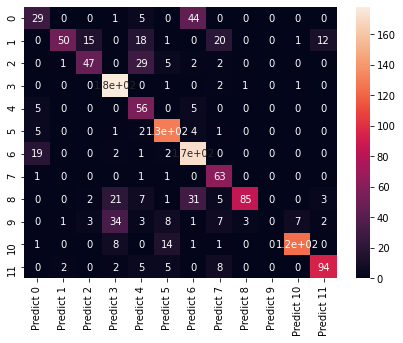

In [127]:
# confusion matrix
cm=confusion_matrix(y2, ypred, labels=[0,1,2,3,4,5,6,7,8,9,10,11])

df_cm = pd.DataFrame(cm, index = [i for i in ["0","1","2","3","4","5","6","7","8","9","10","11"]],
                  columns = [i for i in ["Predict 0","Predict 1","Predict 2","Predict 3","Predict 4","Predict 5",
                                         "Predict 6","Predict 7","Predict 8","Predict 9","Predict 10","Predict 11",]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)

#### Dictionary for data visualization

In [135]:
label_dict =  {10:'Small-flowered Cranesbill', 5:'Fat Hen',9:'Shepherds Purse', 4:'Common wheat',
               3:'Common Chickweed', 1:'Charlock',2:'Cleavers', 8:'Scentless Mayweed',
               11:'Sugar beet',7:'Maize',0:'Black-grass', 6:'Loose Silky-bent'}

## VI] Visualizing results

Black-grass
Sugar beet
Common wheat
Loose Silky-bent
Black-grass


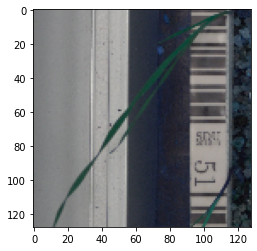

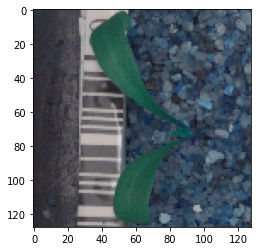

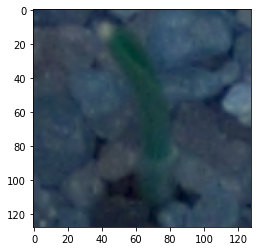

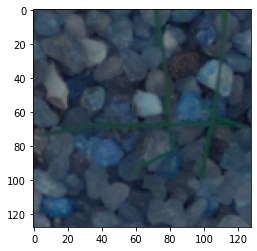

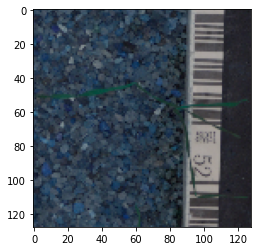

In [142]:
plt.figure()
plt.imshow(x_valid[2])
# print(y_valid[2])
print(label_dict[np.where(y_valid[2])[0][0]])
plt.figure()
plt.imshow(x_valid[3])
# print(y_valid[3])
print(label_dict[np.where(y_valid[3])[0][0]])
plt.figure()
plt.imshow(x_valid[33])
# print(y_valid[33])
print(label_dict[np.where(y_valid[33])[0][0]])
plt.figure()
plt.imshow(x_valid[36])
# print(y_valid[36])
print(label_dict[np.where(y_valid[36])[0][0]])
plt.figure()
plt.imshow(x_valid[59])
# print(y_valid[59])
print(label_dict[np.where(y_valid[59])[0][0]])

Black-grass


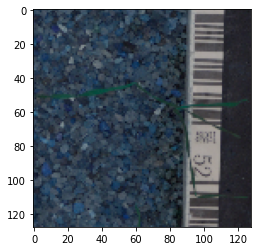

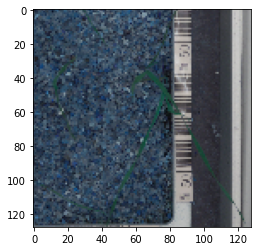

In [148]:
# Plotting figure from predicted data
plt.figure()
plt.imshow(x_valid[59])
# print(y_valid[59])
print(label_dict[np.where(y_valid[59])[0][0]])
# Plotting figure from input data
r1 = np.where(labels=='Black-grass')[0][0]
plt.figure()
plt.imshow(data[r1])

Black-grass


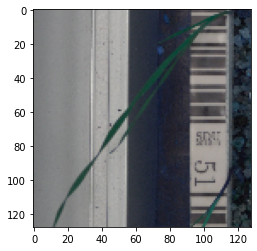

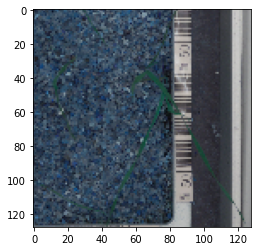

In [149]:
# Plotting figure from predicted data
plt.figure()
plt.imshow(x_valid[2])
# print(y_valid[2])
print(label_dict[np.where(y_valid[2])[0][0]])
# Plotting figure from input data
r1 = np.where(labels=='Black-grass')[0][0]
plt.figure()
plt.imshow(data[r1])

Sugar beet


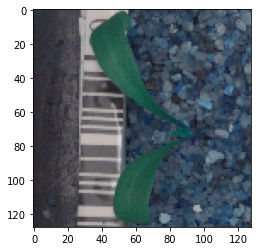

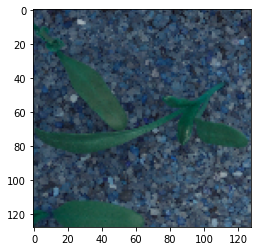

In [150]:
# Plotting figure from predicted data
plt.figure()
plt.imshow(x_valid[3])
# print(y_valid[3])
print(label_dict[np.where(y_valid[3])[0][0]])
# Plotting figure from input data
r1 = np.where(labels=='Sugar beet')[0][0]
plt.figure()
plt.imshow(data[r1])

Common wheat


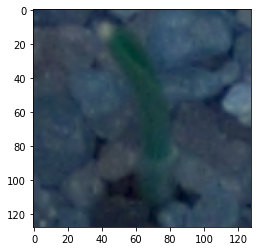

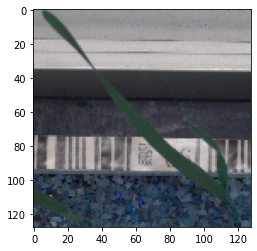

In [151]:
# Plotting figure from predicted data
plt.figure()
plt.imshow(x_valid[33])
# print(y_valid[33])
print(label_dict[np.where(y_valid[33])[0][0]])
# Plotting figure from input data
r1 = np.where(labels=='Common wheat')[0][0]
plt.figure()
plt.imshow(data[r1])

Loose Silky-bent


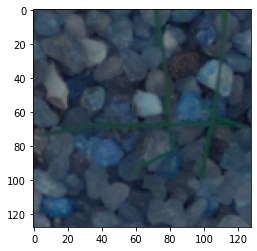

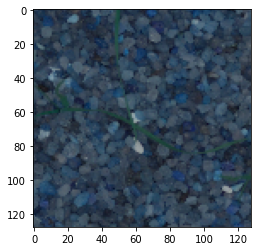

In [152]:
# Plotting figure from predicted data
plt.figure()
plt.imshow(x_valid[36])
# print(y_valid[36])
print(label_dict[np.where(y_valid[36])[0][0]])
# Plotting figure from input data
r1 = np.where(labels=='Loose Silky-bent')[0][0]
plt.figure()
plt.imshow(data[r1])

#### Comment
1. The predicted data and input data match for black grass.
2. The predicted data and input data match for black grass.
3. The predicted data and input data match for Sugar beet.
4. The relation between the predicted and input data cannot be determined for Common wheat.
5. The predicted data and input data match for Loose silky-bent.